# QNN Inspired Time Series Forecasting (Answer)

### Authors
- **Jacob Cybulski**, jacob.cybulski[at]deakin.edu.au<br/>
    School of IT, SEBE, Deakin University, Melbourne, Vic, Australia

### Aims
> *This script aims to create a variational quantum circuit to implement a forecast of a signal spectrum (derived from a continuous function with noise).*

### Primary Sources
- Schuld, Maria, Ryan Sweke, and Johannes Jakob Meyer. 
    "The Effect of Data Encoding on the Expressive Power of Variational Quantum Machine Learning Models." 
    *Physical Review A 103*, no. 3 (March 24, 2021): 032430.<br/> 
    http://arxiv.org/abs/2008.08605<br/>
- PennyLane Dev Team. "Quantum models as Fourier series", Last updated: 15 Jan 2021.<br/>
    https://pennylane.ai/qml/demos/tutorial_expressivity_fourier_series.html
- Brownlee, Jason. 
    *Introduction to Time Series Forecasting with Python How to Prepare Data and Develop Models to Predict the Future.*
    Machine Learning Mastery, 2020.<br/>
    https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/.
- About observables See:<br />
    https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/operators/01_operator_flow.ipynb

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/Dropbox/Dev/Python/qiskit/projects/ts/tqcebt_qtsa',
 '/home/jacob/anaconda3/envs/qiskit/lib/python38.zip',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8/lib-dynload',
 '',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8/site-packages',
 '/home/jacob/anaconda3/envs/qiskit/lib/python3.8/site-packages/IPython/extensions',
 '/home/jacob/.ipython',
 '.']

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import math
from IPython.display import clear_output
%matplotlib inline

from utils import *

In [3]:
debug = True

## Preare windowed version of data
*Values need to be in [0, 1] range*

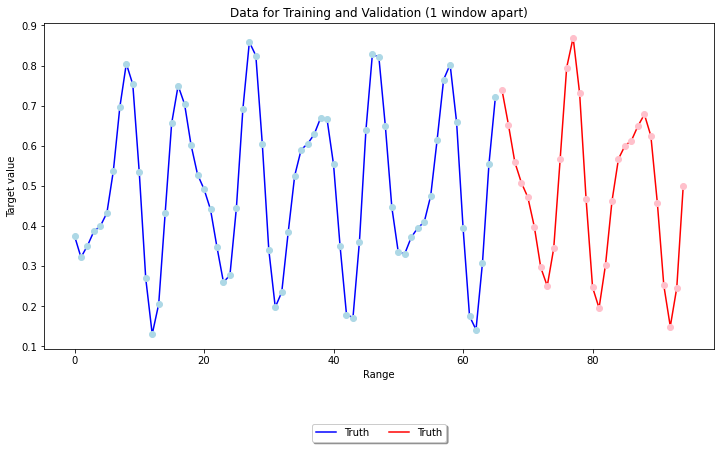

In [4]:
### Start random process
algorithm_globals.random_seed = 2022

### Data settings
samples = 50
train_pc = 0.7
samples_train = int(np.round(samples * train_pc, 0))
samples_valid = samples - samples_train
samples_hi_res = samples*2

### Define the time series parameters
#   wind_size: sliding window size (which may be the same as number of qubits)
#   horizon:   the number of time events to look ahead (to forecast)
wind_size = 5
wind_step = 1
horizon = 1

### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

f = Target_2_sins()

### Define a target function params
lb, ub = f.xrange()
lb_train, ub_train = lb, lb+train_pc*(ub - lb)
lb_valid, ub_valid = lb+train_pc*(ub - lb), ub
eps = f.eps()
T = (ub - lb)

### Prepare all X and y data
X_all = np.linspace(lb, ub, num=samples_hi_res)
y_all = f.fun(X_all)

# Prepare X and y for training
X_train_ts, y_train_ts, X_valid_ts, y_valid_ts = Xy_wind_split(y_all, wind_size, wind_step, horizon, train_pc)

# Plot prepared data
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Data for Training and Validation (1 window apart)")
plt.xlabel("Range")
plt.ylabel("Target value")
# plt.xlim(lb, ub)

# Plot target function
plt.plot(range(X_train_ts.shape[0]), [y[0] for y in y_train_ts], color='blue', label='Truth')
plt.plot(range(X_train_ts.shape[0]), [y[0] for y in y_train_ts], marker='o', color='lightblue', linestyle='None')
plt.plot(range(X_train_ts.shape[0], X_train_ts.shape[0]+X_valid_ts.shape[0]), [y[0] for y in y_valid_ts], color='red', label='Truth')
plt.plot(range(X_train_ts.shape[0], X_train_ts.shape[0]+X_valid_ts.shape[0]), [y[0] for y in y_valid_ts], marker='o', color='pink', linestyle='None')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=2, fancybox=True, shadow=True)
plt.show()

In [5]:
from pprint import pprint

### Show a sample of data
print('\nOriginal training examples (20 y values, X is ignored):')
pprint(y_all[0:20])
print('\nTS X train examples (5 records):')
pprint(X_train_ts[0:5,:])
print('\nTS y train examples (5 records):')
pprint(y_train_ts[0:5,:])
print('\nTS X, y train shape:', X_train_ts.shape, y_train_ts.shape)
print('TS X, y valid shape:', X_valid_ts.shape, y_valid_ts.shape, '\n')


Original training examples (20 y values, X is ignored):
array([0.5       , 0.75444266, 0.85072478, 0.74813221, 0.54229474,
       0.37529953, 0.32180385, 0.35086342, 0.3869433 , 0.40005637,
       0.43250985, 0.53759593, 0.69649509, 0.80470206, 0.75302619,
       0.5335143 , 0.26909808, 0.13031512, 0.2050119 , 0.43217518])

TS X train examples (5 records):
array([[0.5       , 0.75444266, 0.85072478, 0.74813221, 0.54229474],
       [0.75444266, 0.85072478, 0.74813221, 0.54229474, 0.37529953],
       [0.85072478, 0.74813221, 0.54229474, 0.37529953, 0.32180385],
       [0.74813221, 0.54229474, 0.37529953, 0.32180385, 0.35086342],
       [0.54229474, 0.37529953, 0.32180385, 0.35086342, 0.3869433 ]])

TS y train examples (5 records):
array([[0.37529953],
       [0.32180385],
       [0.35086342],
       [0.3869433 ],
       [0.40005637]])

TS X, y train shape: (66, 5) (66, 1)
TS X, y valid shape: (29, 5) (29, 1) 



# Classical MLP Solution (sklearn)

In [6]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve
from sklearn.metrics import r2_score, mean_absolute_percentage_error 

### Prep data for performance testing
Xt = X_train_ts
yt = y_train_ts.reshape(y_train_ts.shape[0],)

In [7]:
### Produce the results with best max_iter
estimator = MLPRegressor(hidden_layer_sizes=(150,100,50), random_state=2022, max_iter=850, activation = 'relu',
                       solver = 'adam', shuffle=True)

regr = estimator.fit(X_train_ts, y_train_ts.reshape(y_train_ts.shape[0],))
yp_train_hat = regr.predict(X_train_ts)
yp_valid_hat = regr.predict(X_valid_ts)

# Score the model
print('Training   score:\t', regr.score(X_train_ts, y_train_ts))
print('MAPE for training:\t', mean_absolute_percentage_error(y_train_ts, yp_train_hat), '\n')

print('Validation score:\t', regr.score(X_valid_ts, y_valid_ts))
print('MAPE for validation:\t', mean_absolute_percentage_error(y_valid_ts, yp_valid_hat), '\n')

Training   score:	 0.8648267887139258
MAPE for training:	 0.14756402645737268 

Validation score:	 0.8484610739451987
MAPE for validation:	 0.15424883311586987 



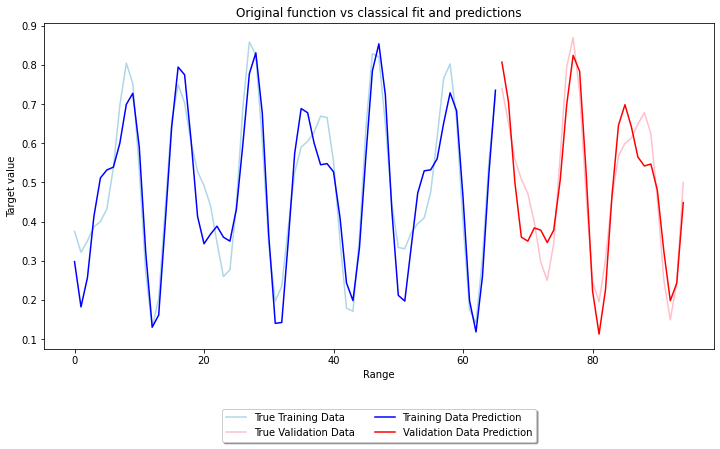

In [8]:
# Plot the data vs fit
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Original function vs classical fit and predictions")
plt.xlabel("Range")
plt.ylabel("Target value")

# Plot target function
plt.plot(range(X_train_ts.shape[0]), [y[0] for y in y_train_ts], color='lightblue', label='True Training Data')
plt.plot(range(X_train_ts.shape[0], X_train_ts.shape[0]+X_valid_ts.shape[0]), [y[0] for y in y_valid_ts], color='pink', label='True Validation Data')

# Plot all predictions
plt.plot(range(X_train_ts.shape[0]), yp_train_hat, color='blue', label='Training Data Prediction')
plt.plot(range(X_train_ts.shape[0], X_train_ts.shape[0]+X_valid_ts.shape[0]), yp_valid_hat, color='red', label='Validation Data Prediction')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=2, fancybox=True, shadow=True)
plt.show()

# Quantum MLP Solution (Qiskit) 

In [9]:
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.opflow import Z, I, StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, TwoLocal, EfficientSU2, PauliFeatureMap
from qiskit.algorithms.optimizers import L_BFGS_B, P_BFGS, COBYLA, NELDER_MEAD, QNSPSA, ADAM, UMDA
from qiskit.compiler import transpile
import qiskit.tools.jupyter

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

In [10]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100, seed_simulator=2022, seed_transpiler=2022)

## Ansatz construction

Create a sliding window QNN

### Sliding window ansatze

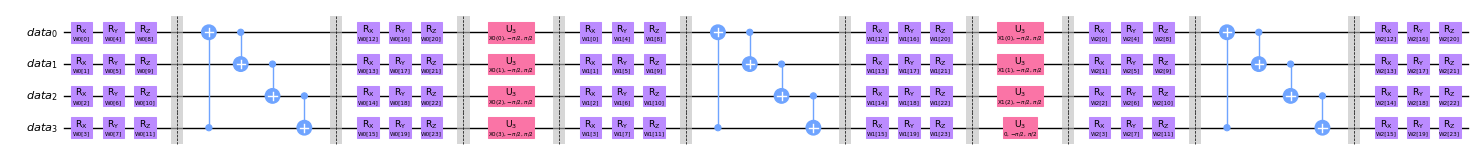

In [11]:
### Serial sliding window ansatz
#   - To be used with CircuitQNN / NeuralNetworkRegressor
#   qubit_no: The number of qubits in the circuit
#   input_no: The number of input values / the size of a sliding window
#   returns
#     Circuit: The serial sliding window ansatz 
#     SParams: The list of parameters used in all S blocks
#     WParams: The list of parameters used in all W blocks
#     Layers: The calculated number of W-S layers in the circuit

def swindow_serial_model(qubit_no, input_no):
    
    sbl_layers = input_no // qubit_no + (0 if input_no % qubit_no == 0 else 1)
    used_sgates = 0

    qr = QuantumRegister(qubit_no, 'data')
    ansatz = QuantumCircuit(qr, name='ansatz')
    SParams = []
    WParams = []

    # Data-encoding circuit block, packs different input vars
    def SN(qubit_no, label):
        nonlocal used_sgates
        s_qr = QuantumRegister(qubit_no)
        s_ansatz = QuantumCircuit(s_qr, name='S')
        for q in range(qubit_no):
            param_x = Parameter(label+'('+str(q)+')') if used_sgates < input_no else 0
            s_ansatz.rx(param_x, q)
            used_sgates += 1
        return s_ansatz

    # Trainable circuit block
    def W(qubit_no, label):
        w_qr = QuantumRegister(qubit_no)
        w_ansatz = QuantumCircuit(w_qr, name='W')
        w_ansatz.append(
            TwoLocal(qubit_no, ['rx', 'ry', 'rz'], 'cx', 
                     entanglement='circular',
                     reps=1, 
                     parameter_prefix=label, 
                     insert_barriers=True,
                     skip_final_rotation_layer=False),
            qargs=w_qr)
        return w_ansatz
    
    for l in range(sbl_layers):
        W1 = W(qubit_no, 'W'+str(l))
        WParams = WParams + W1.parameters[:]
        ansatz.append(W1, qargs=qr)
        ansatz.barrier()
        SX = SN(qubit_no, 'X'+str(l))
        SParams = SParams + SX.parameters[:]
        ansatz.append(SX, qargs=qr)
        ansatz.barrier()

    W1 = W(qubit_no, 'W'+str(sbl_layers))    
    WParams = WParams + W1.parameters[:]
    ansatz.append(W1, qargs=qr)

    return ansatz, SParams, WParams, sbl_layers

# Test a sample serial ansatz
m, input_params, weight_params, layers_no = swindow_serial_model(4, 7)
display(m.decompose().decompose().decompose().draw(output='mpl', fold=False, scale=0.7))
# print('Layers:', layers_no)
# print('Input params:\n', input_params)
# print('\nWeight params:\n', weight_params)

### Construct a QNN inspired model

In [12]:
# Start random process
algorithm_globals.random_seed = 2022

# Define model, its parameters and their initial values (including random input)
print('Sliding window model built')

# Settings for parallel model
parity = lambda x: "{:b}".format(x).count("1") % 2
first_only = lambda x: x % 2
qubits_no = 4
output_shape = 2
model, input_params, weight_params, layers_no = swindow_serial_model(qubits_no, wind_size)
init_weights = algorithm_globals.random.random((layers_no+1)*qubits_no*6) * 2 * np.pi # last block = True

# Construct QNN and show its circuit
regr_qnn = CircuitQNN(model, 
            input_params=input_params, 
            weight_params=weight_params, 
            interpret=parity,
            output_shape=output_shape,
            sparse=False,
            quantum_instance=quantum_instance)

print('Window size:', wind_size, ', Horizon=', horizon, ', Qubits=', qubits_no, ', Layers=', layers_no)

Sliding window model built
Window size: 5 , Horizon= 1 , Qubits= 4 , Layers= 2


### Create and train the model

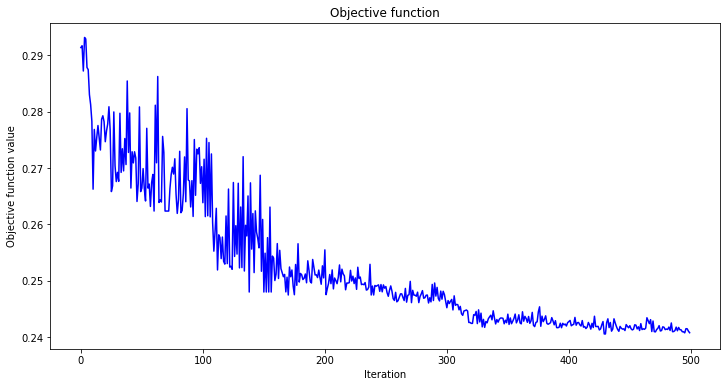

Minimum objective function value: (430, 0.2405966343982094)


In [13]:
### Define a regressor
algorithm_globals.random_seed = 2022

# Recommended optimizers and their parameters:  
#   COBYLA() # COBYLA(maxiter=300) # COBYLA(maxiter=500) - very fast
#   NELDER_MEAD() # NELDER_MEAD(maxiter=100) # NELDER_MEAD(maxiter=500) - slower
#   L_BFGS_B() # L_BFGS_B(maxiter=10) # L_BFGS_B(maxiter=16) - slowwweeer
# Not recommended: 
#   ADAM(maxiter=100) - slow/no callbacks
#   UMDA(maxiter=200) - slow/incorrect callbacks
optimizer = COBYLA(maxiter=500)
regr_callback = Regr_callback()
regr_callback.reset(obfun=[])

regressor = NeuralNetworkRegressor(
    neural_network=regr_qnn,
    loss="squared_error",
    optimizer=optimizer, 
    initial_point=init_weights, 
    # callback=regr_callback.graph
    callback=regr_callback.collect
)

# fit regressor
regressor.fit(X_train_ts, np.array([y[0] for y in y_train_ts]))

### Find the optimum objective fun value
regr_callback.plot()
print('Minimum objective function value:', regr_callback.min_obj())

## Score the model

In [14]:
### Calculate the score

from sklearn.metrics import r2_score, mean_absolute_percentage_error 

yp_train = np.array([[1-yi[0], yi[0]] for yi in y_train_ts])
yp_train_true = np.array([yi[0] for yi in y_train_ts])
yp_train_hat = np.array([y1 for y0, y1 in regressor.predict(X_train_ts)])
print('R2 for pred vs training data:\t\t', regressor.score(X_train_ts, yp_train))
print('MAPE for pred vs training data:\t\t', mean_absolute_percentage_error(yp_train_true, yp_train_hat), '\n')

yp_valid = np.array([[1-yi[0], yi[0]] for yi in y_valid_ts])
yp_valid_true = np.array([yi[0] for yi in y_valid_ts])
yp_valid_hat = np.array([y1 for y0, y1 in regressor.predict(X_valid_ts)])
print('R2 for pred vs validation data:\t\t', regressor.score(X_valid_ts, yp_valid))
print('MAPE for pred vs validation data:\t', mean_absolute_percentage_error(yp_valid_true, yp_valid_hat))

R2 for pred vs training data:		 0.7097045127054364
MAPE for pred vs training data:		 0.22115537811985556 

R2 for pred vs validation data:		 0.6280795019633996
MAPE for pred vs validation data:	 0.26029788250150215


## Plot the results

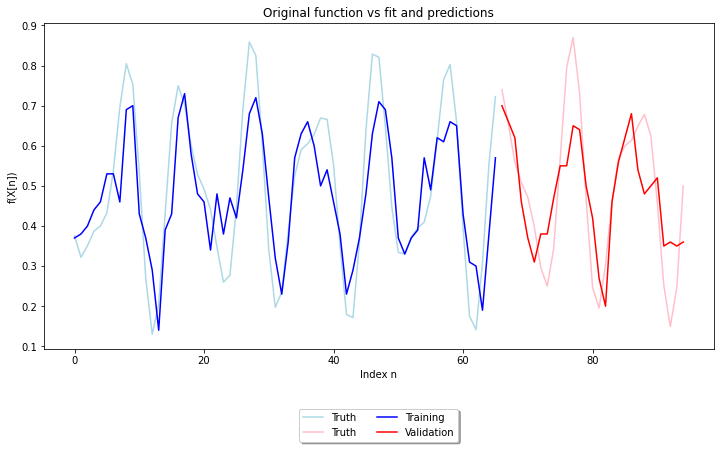

In [15]:
### Find predictions for the past and future data

# Prepare the plot
plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Original function vs fit and predictions")
plt.xlabel("Index n")
plt.ylabel("f(X[n])")
# plt.xlim(lb, ub)

# Plot target function
offset = wind_size-1
plt.plot(range(X_train_ts.shape[0]), [y[0] for y in y_train_ts], color='lightblue', label='Truth')
plt.plot(range(X_train_ts.shape[0], X_train_ts.shape[0]+X_valid_ts.shape[0], 1), [y[0] for y in y_valid_ts], color='pink', label='Truth')

# Plot all predictions
plt.plot(range(X_train_ts.shape[0]), yp_train_hat, color='blue', label='Training')
plt.plot(range(X_train_ts.shape[0], X_train_ts.shape[0]+X_valid_ts.shape[0], 1), yp_valid_hat, color='red', label='Validation')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
          ncol=2, fancybox=True, shadow=True)
plt.show()

## Versions
- V8 (17/9/2022)<br/>
    Commenced work on a custom forecasting model
    - V8.8 - Adapted for TQCEBT workshop

In [16]:
import qiskit.tools.jupyter

%qiskit_version_table